# UJM - Master DSC/MLDM - Deep Learning - TP2b - GANs

## Part . GAN (Generative Adversarial Network)


The following code is from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
#import keras.backend as K
import tensorflow as tf

import random
import matplotlib.pyplot as plt
import sys
import numpy as np

# Configure TensorFlow to use Metal GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Physical devices:", tf.config.list_physical_devices())

# Set memory growth for GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for Metal GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configured: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU devices found. Using CPU.")

TensorFlow version: 2.16.2
Num GPUs Available:  1
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU configured: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Build the Generator**

In [2]:
noise_shape = (100,)
img_shape = (28,28,1)

# Use GPU if available, otherwise CPU
device = "/device:GPU:0" if tf.config.list_physical_devices('GPU') else "/device:CPU:0"
print(f"Building generator on: {device}")

with tf.device(device):
  model = Sequential()
  model.add(Input(shape=noise_shape))
  model.add(Dense(256))
  model.add(LeakyReLU(negative_slope=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(negative_slope=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(negative_slope=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(784, activation='tanh'))
  model.add(Reshape(img_shape))

  model.summary()

  noise = Input(shape=noise_shape)
  img = model(noise)

  generator =  Model(inputs = noise, outputs = img)

Building generator on: /device:GPU:0


2025-11-30 13:25:08.029921: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-30 13:25:08.029945: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-30 13:25:08.029951: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-30 13:25:08.029969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-30 13:25:08.029980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

**Build the Discriminator**

In [3]:
# Use GPU if available, otherwise CPU
device = "/device:GPU:0" if tf.config.list_physical_devices('GPU') else "/device:CPU:0"
print(f"Building discriminator on: {device}")

with tf.device(device):
  model = Sequential()

  model.add(Input(shape=img_shape))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(LeakyReLU(negative_slope=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(negative_slope=0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  discriminator =  Model(inputs = img, outputs = validity)

Building discriminator on: /device:GPU:0


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

**Function to print out images**

In [4]:
def print_imgs():
    r, c = 2, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = (1/2.5) * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c, figsize=(20, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

**Train the model.** Note: If you rerun the model, it will continue with the left off weights. To train from scratch, please recompile your model.

In [5]:
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


In [6]:
batch_size = 256 

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
train_iterator = iter(dataset.repeat())
print(dataset)

<_PrefetchDataset element_spec=TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name=None)>


Starting optimized training on: /device:GPU:0


2025-11-30 13:25:09.174496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


0 [D loss: 0.6048] [G loss: 0.5634]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


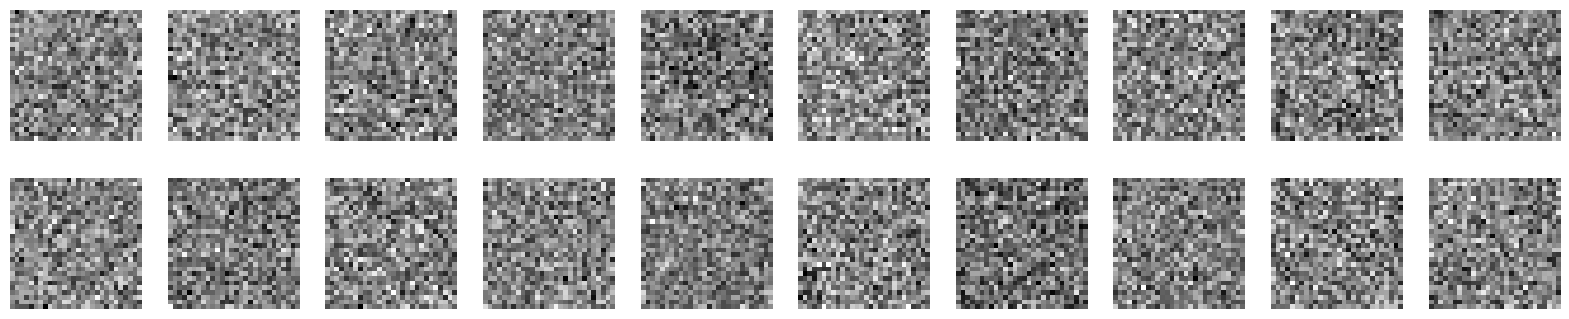

1000 [D loss: 0.6136] [G loss: 1.0195]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


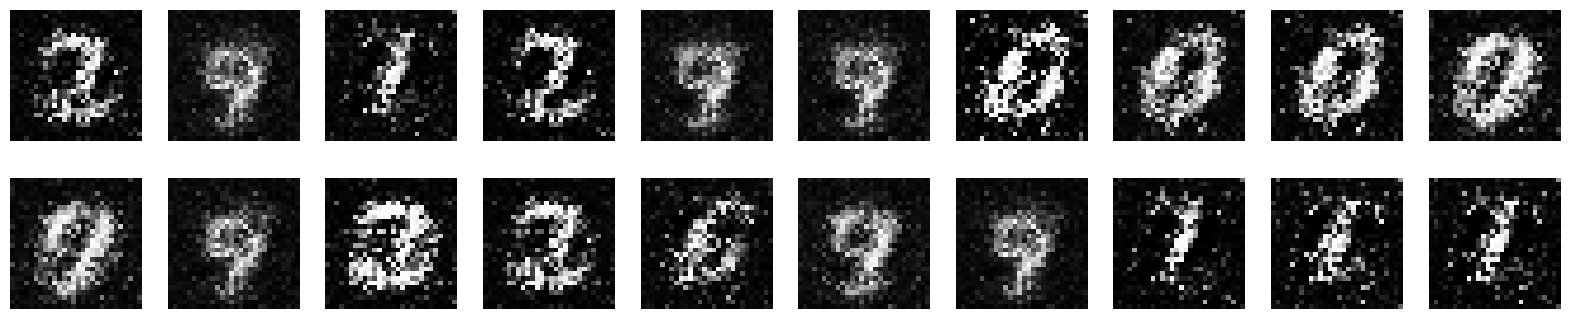

2000 [D loss: 0.6105] [G loss: 0.8507]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


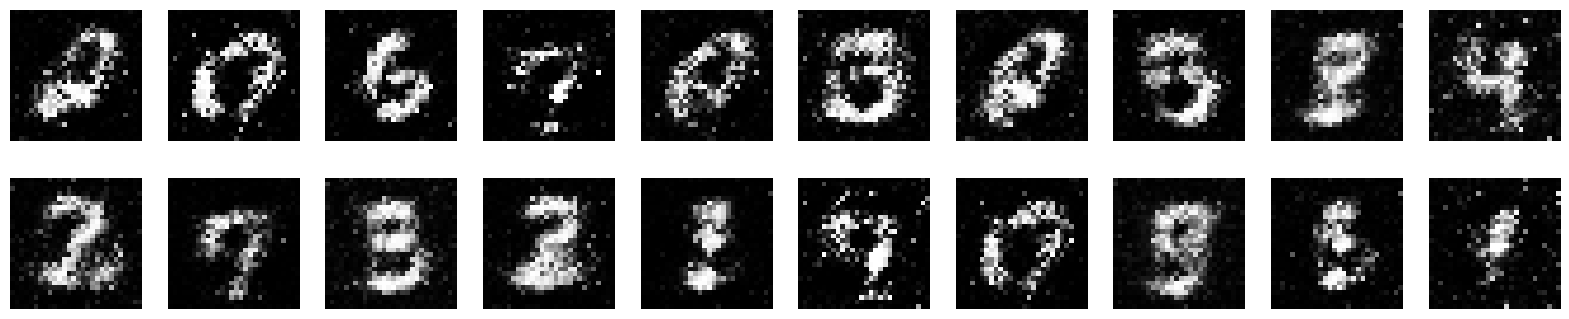

3000 [D loss: 0.6158] [G loss: 0.9462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


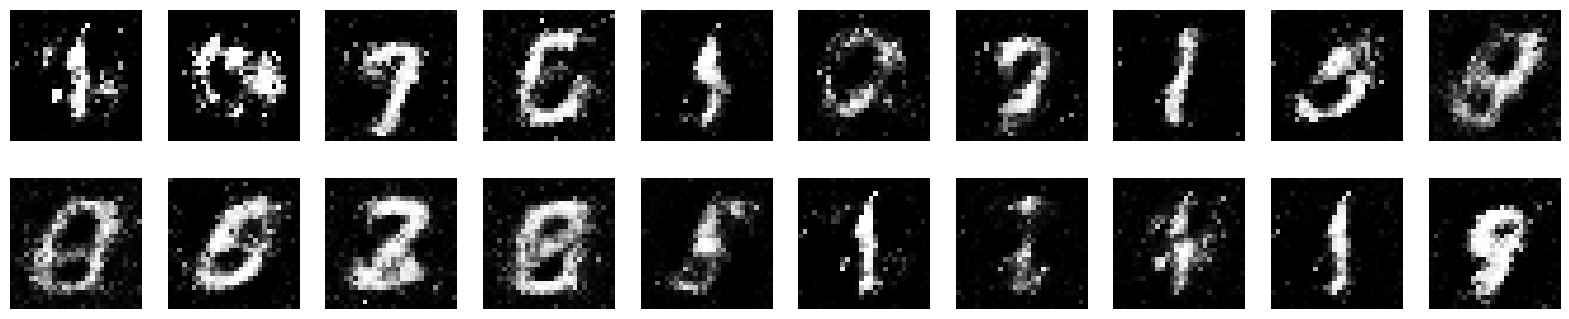

4000 [D loss: 0.6267] [G loss: 1.0689]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


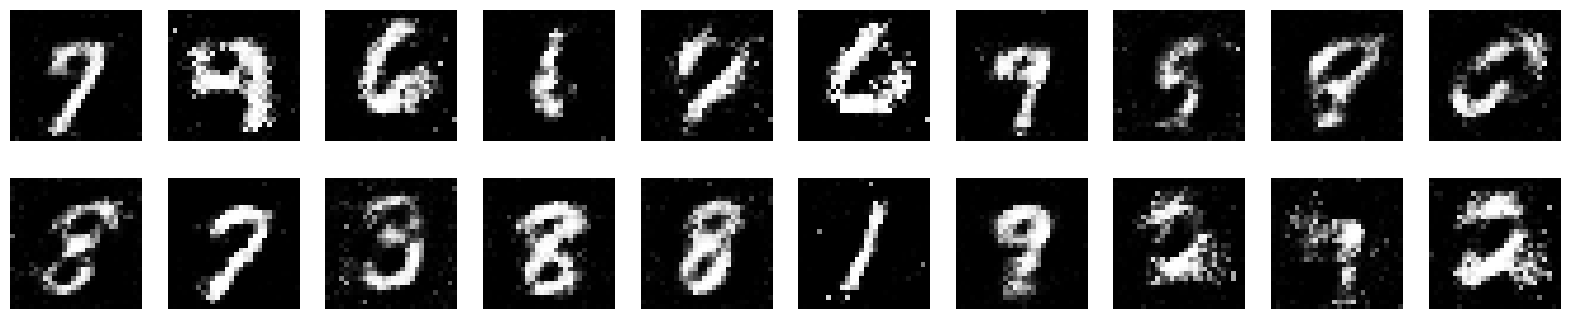

5000 [D loss: 0.6444] [G loss: 0.7410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


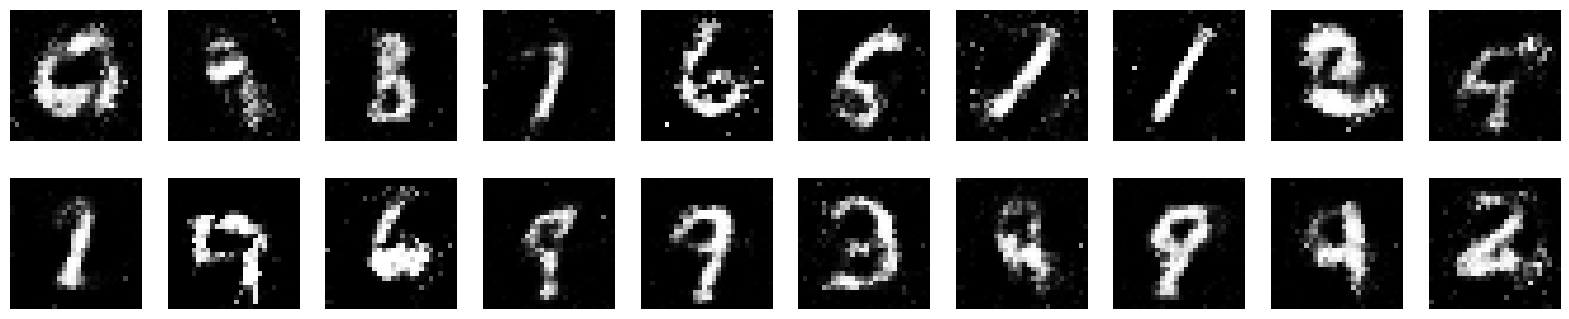

6000 [D loss: 0.6585] [G loss: 0.9898]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


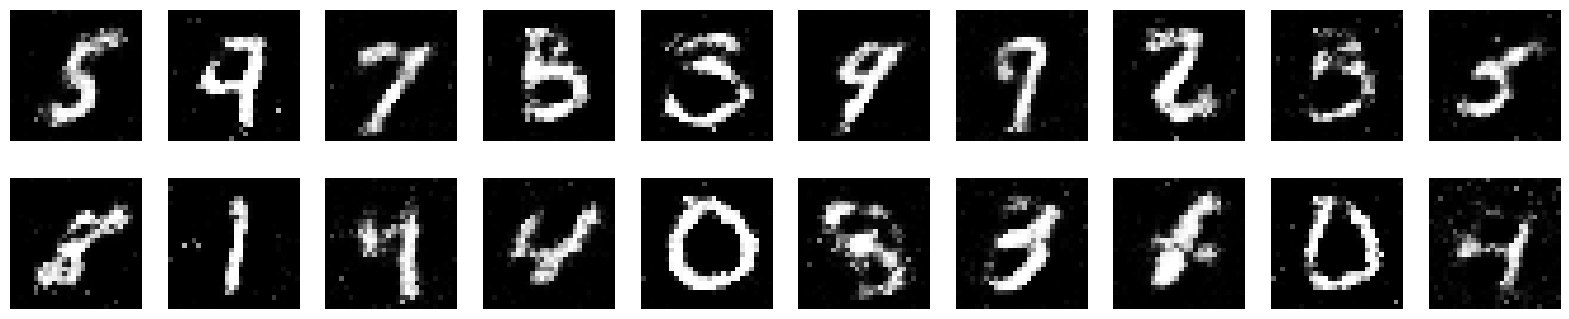

7000 [D loss: 0.6358] [G loss: 0.8660]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


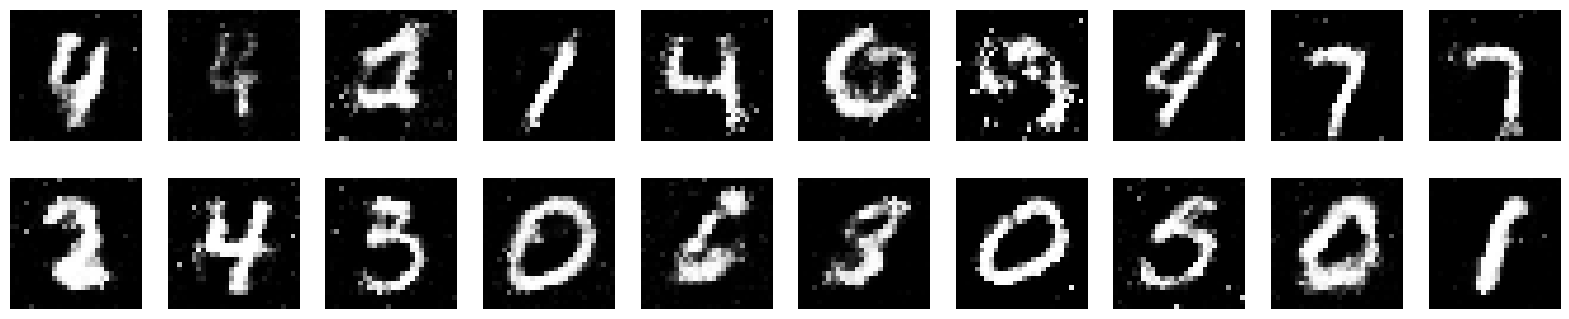

8000 [D loss: 0.6623] [G loss: 0.8699]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


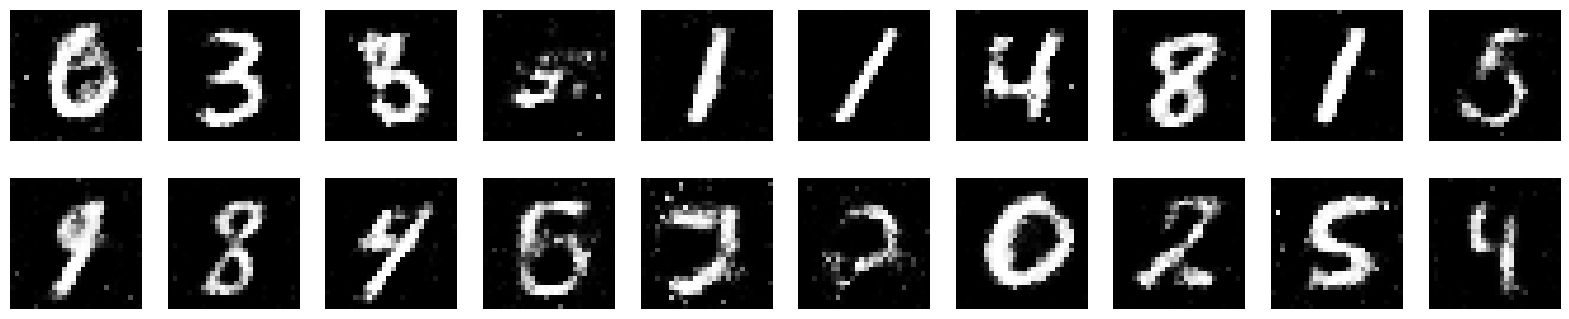

9000 [D loss: 0.6266] [G loss: 0.7593]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


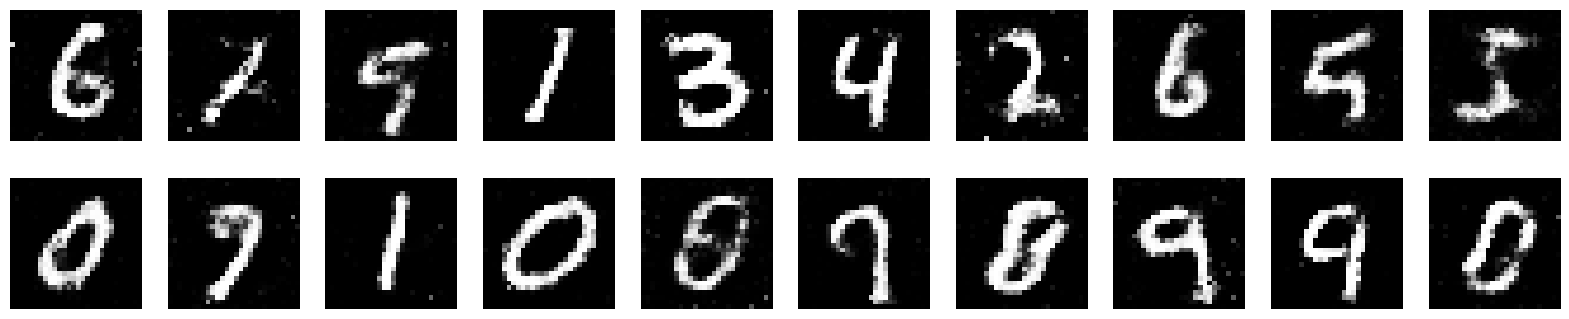

Training finished in 213.56s


In [7]:
import time

d_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
g_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

discriminator.trainable = True 

@tf.function
def train_step(real_images):
    current_batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([current_batch_size, 100])

    # --- Train Discriminator ---
    with tf.GradientTape() as d_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        d_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        d_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
    
    gradients_of_d = d_tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(gradients_of_d, discriminator.trainable_variables))
    
    # --- Train Generator ---
    with tf.GradientTape() as g_tape:
        noise = tf.random.normal([current_batch_size, 100])
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        g_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
    gradients_of_g = g_tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients_of_g, generator.trainable_variables))
    
    return d_loss, g_loss

print(f"Starting optimized training on: {device}")
start_time = time.time()

epochs = 10000

for epoch in range(epochs):
    batch_imgs = next(train_iterator)
    d_loss, g_loss = train_step(batch_imgs)

    if epoch % 1000 == 0:
        print (f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
        print_imgs()

print(f"Training finished in {time.time() - start_time:.2f}s")
